/home/philipslinux/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/philipslinux/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_36234/1569085547.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Epoch [1/20], Train Loss: 0.5005, Train Acc: 0.6036
Epoch [2/20], Train Loss: 0.3564, Train Acc: 0.8358
Epoch [3/20], Train Loss: 0.2844, Train Acc: 0.8663
Epoch [4/20], Train Loss: 0.2417, Train Acc: 0.8647
Epoch [5/20], Train Loss: 0.2189, Train Acc: 0.8796
Epoch [6/20], Train Loss: 0.2024, Train Acc: 0.8898
Epoch [7/20], Train Loss: 0.1831, Train Acc: 0.8944
Epoch [8/20], Train Loss: 0.1654, Train Acc: 0.9124
Epoch [9/20], Train Loss: 0.1464, Train Acc: 0.9163
Epoch [10/20], Train Loss: 0.1318, Train Acc: 0.9234
Epoch [11/20], Train Loss: 0.1164, Train Acc: 0.9335
Epoch [12/20], Train Loss: 0.0971, Train Acc: 0.9507
Epoch [13/20], Train Loss: 0.0869, Train Acc: 0.9570
Epoch [14/20], Train Loss: 0.0723, Train Acc: 0.9805
Epoch [15/20], Train Loss: 0.0634, Train Acc: 0.9789
Epoch [16/20], Train Loss: 0.0542, Train Acc: 0.9914
Epoch [17/20], Train Loss: 0.0514, Train Acc: 0.9906
Epoch [18/20], Train Loss: 0.0473, Train Acc: 0.9930
Epoch [19/20], Train Loss: 0.0426, Train Acc: 0.9953
Ep

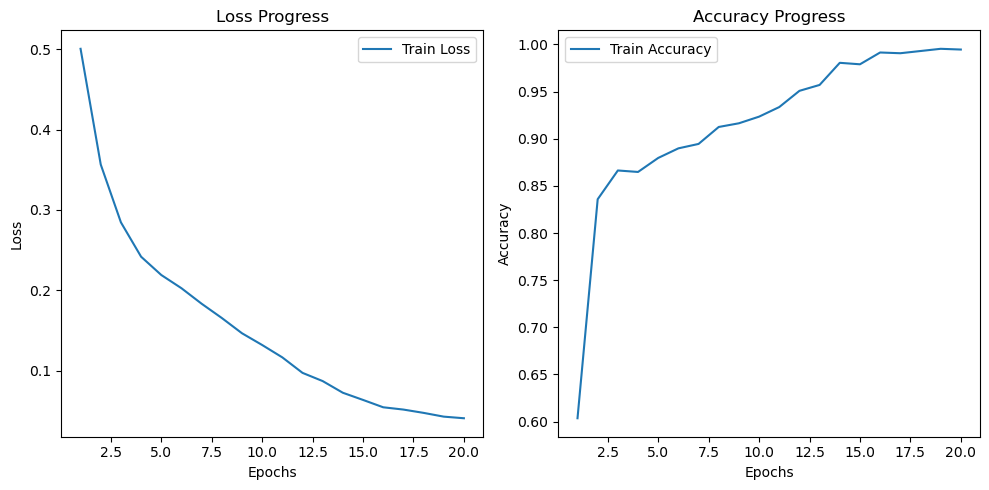

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
class TeacherNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(TeacherNetwork, self).__init__()
        self.backbone1 = models.resnet152(pretrained=True)
        self.feature_extractor1 = nn.Sequential(*list(self.backbone1.children())[:-2])
        self.feature_extractor2 = nn.Sequential(*list(self.backbone1.children())[:-50])
        self.feature_extractor3 = nn.Sequential(*list(self.backbone1.children())[:-100])
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.local_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(34816, 256)
        self.fc2 = nn.Linear(51, 256)
        self.fc3 = nn.Linear(51, 256)
        self.fc_out1 = nn.Linear(256, num_classes)
        self.fc_out2 = nn.Linear(256, num_classes)
        self.fc_out3 = nn.Linear(256, num_classes)
        self.fc_out_final = nn.Linear(6, num_classes)
    def forward(self, x):
        features1 = self.feature_extractor1(x)
        global_features1 = self.global_pool(features1).view(x.size(0), -1)
        local_features1 = self.local_pool(features1).view(x.size(0), -1)
        combined_features1 = torch.cat((global_features1, local_features1), dim=1)
        features2 = self.feature_extractor2(x)
        global_features2 = self.global_pool(features2).view(x.size(0), -1)
        local_features2 = self.local_pool(features2).view(x.size(0), -1)
        combined_features2 = torch.cat((global_features2, local_features2), dim=1)
        features3 = self.feature_extractor3(x)
        global_features3 = self.global_pool(features3).view(x.size(0), -1)
        local_features3 = self.local_pool(features3).view(x.size(0), -1)
        combined_features3 = torch.cat((global_features3, local_features3), dim=1)
        out1 = self.fc_out1(self.fc1(combined_features1))
        out2 = self.fc_out2(self.fc2(combined_features2))
        out3 = self.fc_out3(self.fc3(combined_features3))
        out_cat = torch.cat((out1, out2, out3), dim=1)
        final_out = self.fc_out_final(out_cat)
        return final_out, out1, out2, out3
class StudentNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentNetwork, self).__init__()
        self.backbone = models.mobilenet_v2(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = True
        self.backbone.classifier[1] = nn.Linear(self.backbone.last_channel, num_classes)
    def forward(self, x):
        out = self.backbone(x)
        return out
def distillation_loss(student_outputs, teacher_outputs, temperature=2.0):
    student_prob = F.softmax(student_outputs / temperature, dim=1)
    teacher_prob = F.softmax(teacher_outputs / temperature, dim=1)
    loss = F.kl_div(student_prob.log(), teacher_prob, reduction='batchmean')
    return loss
def total_loss(student_output, teacher_output, target, temperature=2.0, alpha=0.5):
    classification_loss = F.cross_entropy(student_output, target)
    distill_loss = distillation_loss(student_output, teacher_output, temperature)
    loss = alpha * classification_loss + (1 - alpha) * distill_loss
    return loss
def train(student_model, teacher_model, dataloader, optimizer, temperature=2.0, alpha=0.5):
    student_model.train()
    teacher_model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
            teacher_outputs, _, _, _ = teacher_model(inputs)
        student_outputs = student_model(inputs)
        loss = total_loss(student_outputs, teacher_outputs, labels, temperature, alpha)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(student_outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    train_accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), train_accuracy
def validate(student_model, dataloader):
    student_model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            student_outputs = student_model(inputs)
            loss = F.cross_entropy(student_outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), val_accuracy
def save_checkpoint(model, epoch, val_acc, checkpoint_path="best_model.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'val_accuracy': val_acc,
    }, checkpoint_path)
if __name__ == '__main__':
    teacher_model = TeacherNetwork(num_classes=2).cuda()
    teacher_model_ckpt = "./checkpoints/best_model_res152_dif_p1.pth"
    teacher_model.load_state_dict(torch.load(teacher_model_ckpt))
    student_model = StudentNetwork(num_classes=2).cuda()
    optimizer = optim.Adam(student_model.parameters(), lr=0.00001)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    train_set = datasets.ImageFolder(root="./syn_vision_dataset/train", transform=transform)
    train_loader = DataLoader(train_set, batch_size=28, shuffle=True)
    best_train_acc = 0.0
    num_epochs = 20
    train_losses = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(student_model, teacher_model, train_loader, optimizer, temperature=2.0, alpha=0.5)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            save_checkpoint(student_model, epoch, best_train_acc)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Progress')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Progress')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()